# Read in the data

In [33]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [34]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [35]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [36]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [37]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [38]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [39]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [40]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [41]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

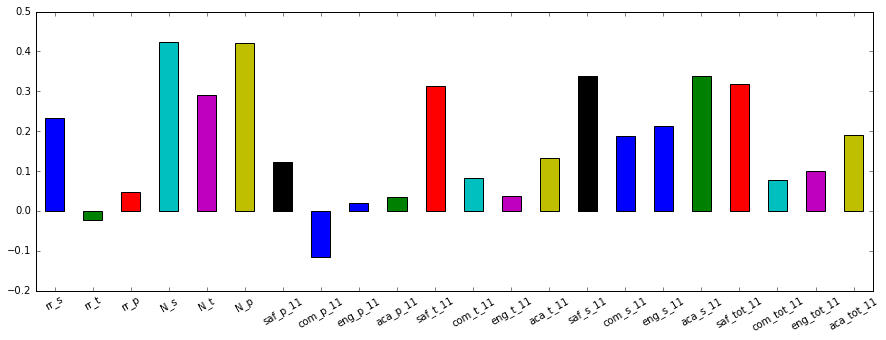

In [50]:
survey_correlations=combined.corr().loc['sat_score',survey_fields]
survey_correlations.plot.bar(rot=30,y='Correlation with sat_score',figsize=(15,5))

We found that the following columns correlate with `sat_score` (r>0.25):

* `rr_S`:Student Response Rate
* `N_s`: Number of student respondents
* `N_t`: Number of teacher respondents
* `N_p`: Number of parent respondents
* `saf_t_11`: Safety and Respect score based on teacher responses
* `saf_s_11`: Safety and Respect score based on student responses
* `aca_s_11`: Academic expectations score based on student responses
* `saf_tot_11`: Safety and Respect total score

Surprisingly, there is a positive correlation between the number of respondents and the SAT score of a school. Indeed, a high number of respondents (students, parents and teachers) is linked to a bigger school with a larger number of students. One might think that smaller schools focus more on each student which would improve their perfomance on the SAT, but this is not the case. 

Another interesting results is the positive correlation with the safety and respect scores.



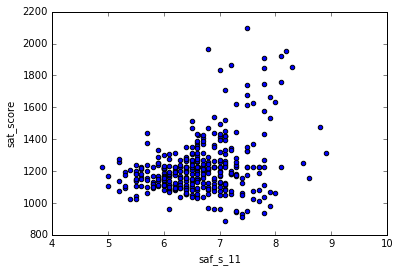

In [52]:
combined.plot.scatter(x='saf_s_11',y='sat_score')

Although there is a positive correlation between `saf_s_11` and `sat_score`, there isn't a linear relationship between them. The correlation is mostly affected by the cluster of data points that represent schools with a low SAT score and a low safety score.
Hence schools with a low safety score tend to have a lower SAT average, but schools with higher safaety scores have dispersed SAT averages. 

In [73]:
districts=combined.copy()
districts['district']=combined['DBN'].apply(lambda s:s[2])
districts=districts.groupby('district').agg(numpy.mean)
districts['saf_s_11']

district
K    6.370755
M    6.831370
Q    6.721875
R    6.530000
X    6.606577
Name: saf_s_11, dtype: float64

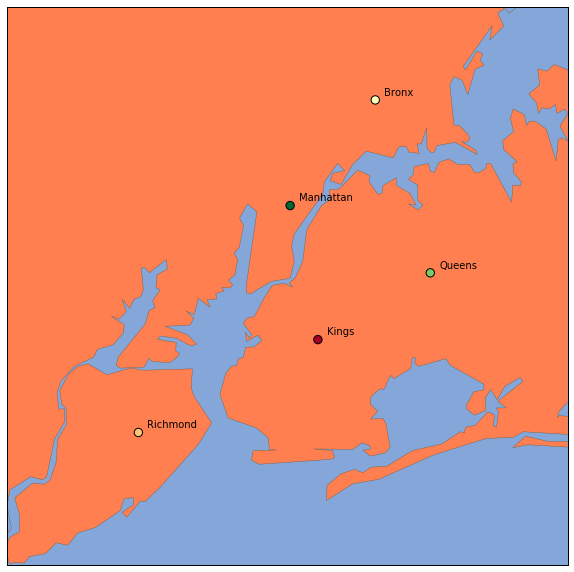

In [91]:
longitudes=districts['lon'].tolist()
latitudes=districts['lat'].tolist()
## MAP
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(18,10))
m=Basemap(projection='merc',
          llcrnrlat=40.496044,
          urcrnrlat=40.915256,
         llcrnrlon=-74.255735,
         urcrnrlon=-73.700272,
         resolution='h')

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47',linewidth=.4)
m.fillcontinents(color='coral')
#m.drawrivers(color='#6D5F47',linewidth=.4)
x,y = m(longitudes, latitudes)
m.scatter(longitudes,latitudes,s=70,zorder=2,latlon=True,c=districts['saf_s_11'],cmap='RdYlGn')

labels = ['Kings','Manhattan','Queens','Richmond','Bronx']
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt+1000, ypt+500, label)

Although Kings district has the lowest safety score, all the districts have an average safety score that ranges from 6.37 to 6.83. We can conclude that the safety score of a school is not linked with the district it is in.

# Correlation between SAT scores and race

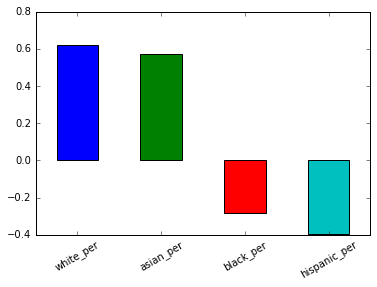

In [97]:
race_cols=['white_per','asian_per','black_per','hispanic_per']
race_corr=combined.corr().loc['sat_score',race_cols]
race_corr.plot(kind='bar',rot=30)

We can observe a strong positive correlation of the SAT score with `white_per` and `asian_per`, as well as a strong negative correlation hispanic_per.
Let us further explore schools with high values for `hispanic_per`.

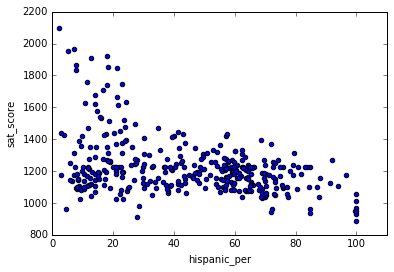

In [104]:
combined.plot.scatter(x='hispanic_per',y='sat_score',xlim=(0,110))

The scatter plot shows a negative linear relationship between schools' SAT scores and the percentage of hispanics. In fact, no school with more than 25% `hispanic_per` has an average SAT score of more than 1600. 
We also observe that 100% hispanic schools have average scores between 800 and 1100, which is considered a poor score on the SAT.

Let us take a look at schools with a `hispanic_per` greater than 95%:

In [108]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

We found out by researching the above schools that most of them are public.

Exploring Gender and SAT Scores

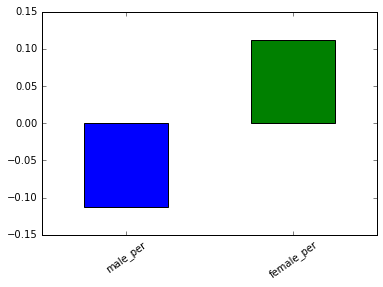

In [114]:
gender_corr=combined.corr().loc['sat_score',['male_per','female_per']]
gender_corr.plot(kind='bar',rot=35)

There is a weak *negative* correlation between SAT score and male percentages in schools, as well as a weak *positive* correlation between scores and female percentages. 

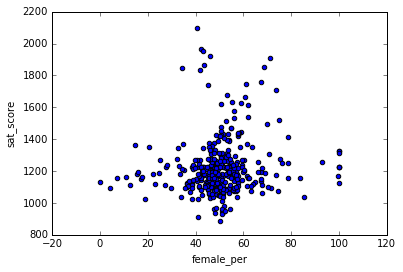

In [115]:
combined.plot.scatter(x='female_per',y='sat_score')

The Data is clustered around 50% female_per and 1200 sat_score. The correlations we observed are due to some schools with a percentage of females between 60% and 80% that have high SAT scores.
Let us look further into this result

In [118]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of these schools are magnet high schools which are selective and competitive. 

# Exploring AP Scores vs. SAT Scores

In [120]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']

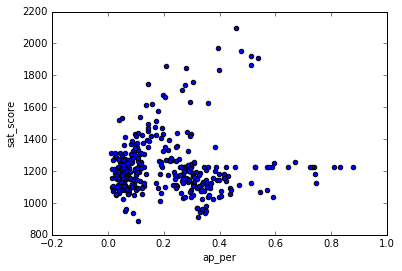

In [121]:
combined.plot.scatter(x='ap_per',y='sat_score')

There is a cluster of schools with a low AP Test takers percentage and a low average SAT score